In [1]:
import pandas as pd
import folium as fo
import numpy as np
import matplotlib.pyplot as plt
import json
pd.set_option('mode.chained_assignment', None)

In [144]:
violations = pd.read_parquet('resources/violations_oriented.parquet')
violations['Year'] = violations['Inspection Date'].map(lambda x: x.year)
violations['Month'] = violations['Inspection Date'].map(lambda x: x.month)
violations = violations[['Ward', 'Year', 'Month', 'Violation ID']][(violations.Year < 2018) & (violations.Year > 2009)]
violations['Count'] = 1

In [90]:
violations_per_month = violations.groupby(by=['Violation ID', 'Year', 'Month']).agg(sum)['Count']

In [91]:
v = violations_per_month.reset_index()
v.index = v['Violation ID']
v['Date'] = v[['Year', 'Month']].apply(lambda x: pd.to_datetime(str(x.Month) + "/" + str(x.Year)), axis=1)
v = v.drop(['Violation ID', 'Year', 'Month'], axis=1).reset_index()

In [137]:
ids = v[v['Violation ID'] != 45]['Violation ID'].unique()
violations_meaning = pd.read_csv('resources/violation-id-meaning.csv', index_col='Violation ID')

In [ ]:
fig, axs = plt.subplots(len(ids), 1, figsize=(18,200))
for i, vid in enumerate(ids):
    filtered = v[v['Violation ID'] == vid]
    rolling_mean = filtered.Count.rolling(window=6).mean()
    axs[i].set_title('Violation #{}: {}'.format(vid, violations_meaning.loc[vid, 'Meaning']))
        
    axs[i].plot(filtered['Date'].values, rolling_mean, 'red')
    axs[i].plot(filtered['Date'].values, filtered['Count'].values)

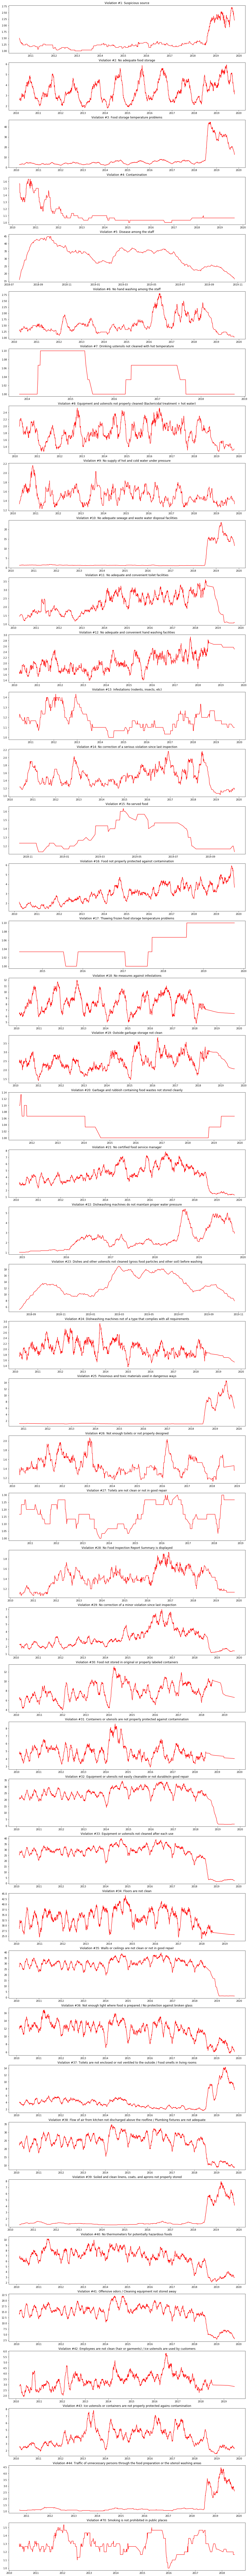

In [155]:
violations2 = pd.read_parquet('resources/violations_oriented.parquet')
violations2 = violations2[['Ward', 'Inspection Date', 'Violation ID']]
violations2['Count'] = 1
violations_per_day = violations2.groupby(by=['Violation ID', 'Inspection Date']).agg(sum)['Count']

v2 = violations_per_day.reset_index()
v2.index = v2['Violation ID']
v2 = v2.drop(['Violation ID'], axis=1).reset_index()

fig, axs = plt.subplots(len(ids), 1, figsize=(18,200))
for i, vid in enumerate(ids):
    filtered = v2[v2['Violation ID'] == vid]
    rolling_mean = filtered.Count.rolling(window=30).mean()
    axs[i].set_title('Violation #{}: {}'.format(vid, violations_meaning.loc[vid, 'Meaning']))
        
    axs[i].plot(filtered['Inspection Date'].values, rolling_mean, 'red')

## Violation frequency by category

In [17]:
violation_category_mapping = pd.read_csv('resources/violation-id-meaning.csv').rename(columns={'Violation ID': 'id', 'Category': 'category'})
violation_category_mapping.index = violation_category_mapping.id
violation_category_mapping = violation_category_mapping.category

violation_categories = violation_category_mapping.unique()
violation_category_mapping.head()

id
1    Food safety
2    Food safety
3    Food safety
4    Food safety
5        Hygiene
Name: category, dtype: object

In [21]:
categorized_violations = pd.read_parquet('resources/violations_oriented.parquet').rename(columns={'Violation ID': 'id', 'Inspection Date': 'date'})
categorized_violations.index = categorized_violations.date
categorized_violations['category'] = categorized_violations.id.map(lambda x: violation_category_mapping.get(x))
categorized_violations = categorized_violations[['category']]
categorized_violations['v_count'] = 1
categorized_violations = categorized_violations.groupby(by=['date', 'category']).sum()

In [23]:
categorized_violations.head()

v_count
date       category            
2010-01-04 Equipment          7
           Hygiene            9
2010-01-05 Equipment         82
           Food safety        3
           Hygiene          145

In [25]:
inspections_per_day = pd.read_parquet('resources/food-inspections-cleaned.parquet').rename(columns={'Inspection Date': 'date'})
inspections_per_day['i_count'] = 1
inspections_per_day = inspections_per_day[['date', 'i_count']]
inspections_per_day = inspections_per_day.groupby(by='date').sum()
inspections_per_day.head()

,i_count
date,
2010-01-04,7
2010-01-05,68
2010-01-06,78
2010-01-07,61
2010-01-08,43


In [34]:
normalized_violation_rate = categorized_violations.join(inspections_per_day)
normalized_violation_rate['rate'] = normalized_violation_rate.v_count / normalized_violation_rate.i_count
normalized_violation_rate = normalized_violation_rate[['rate']].reset_index()
normalized_violation_rate.head()

,date,category,rate
0,2010-01-04,Equipment,1.000000
1,2010-01-04,Hygiene,1.285714
2,2010-01-05,Equipment,1.205882
3,2010-01-05,Food safety,0.044118
4,2010-01-05,Hygiene,2.132353


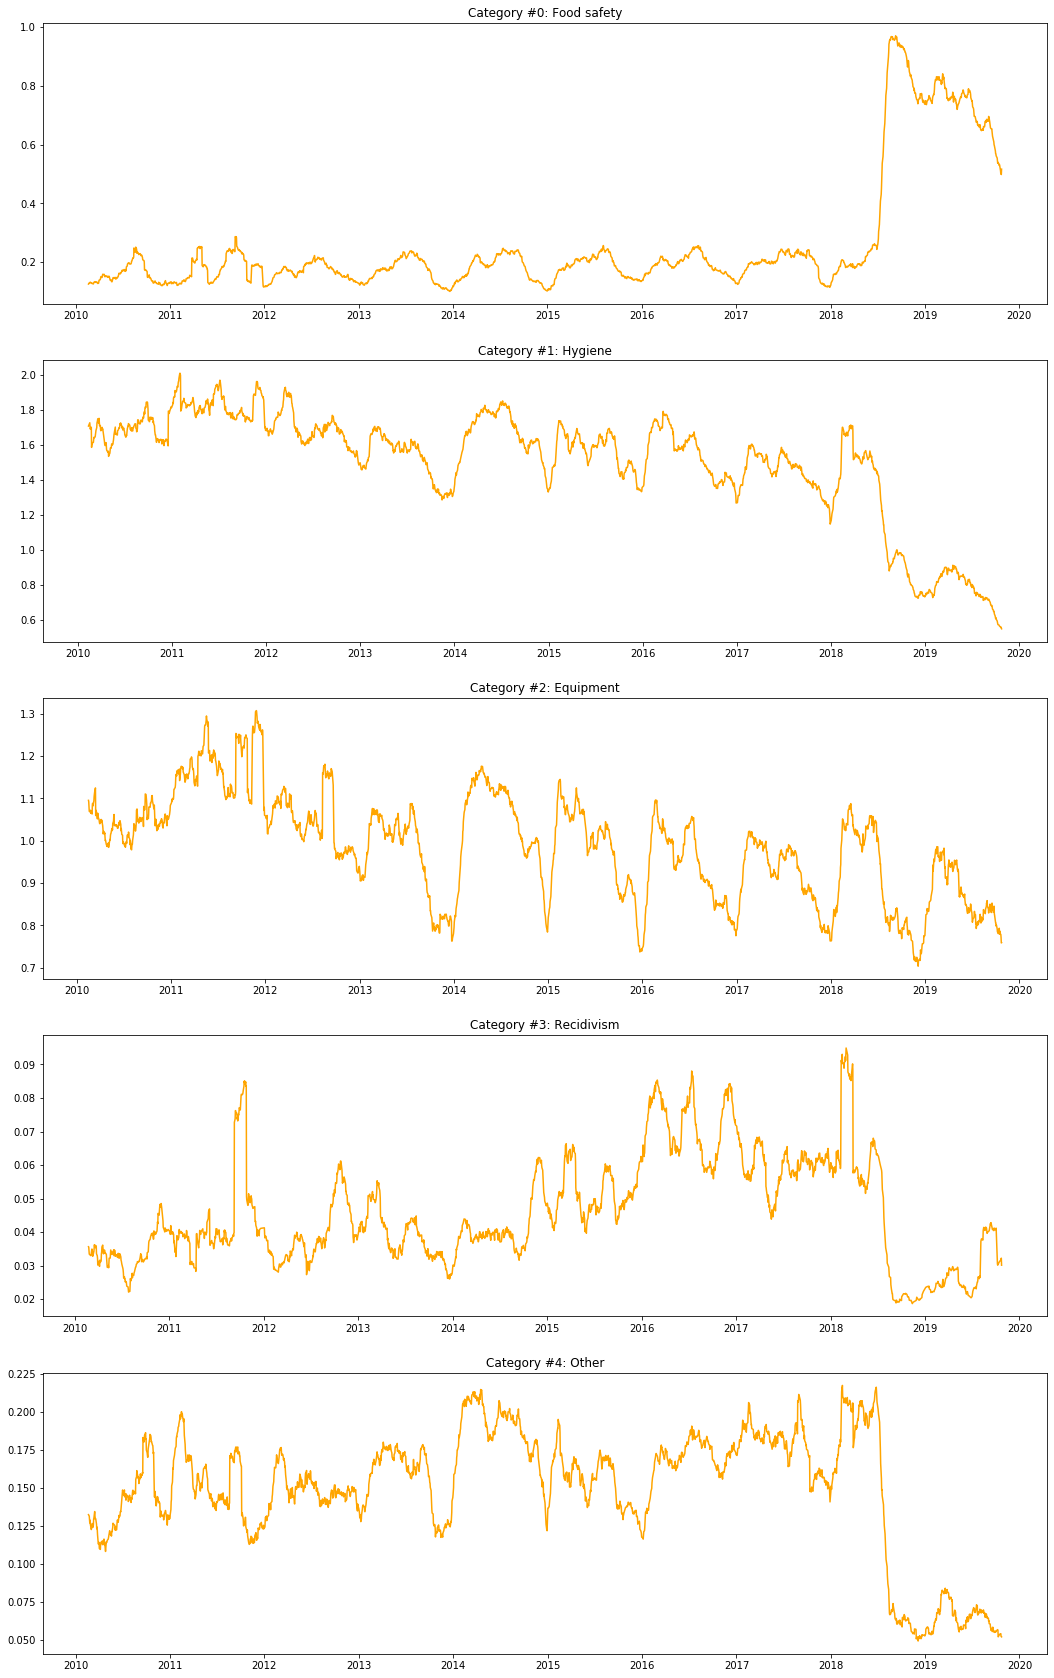

In [38]:
fig, axs = plt.subplots(len(violation_categories), 1, figsize=(18,30))

for i, v_cat in enumerate(violation_categories):
    filtered = normalized_violation_rate[normalized_violation_rate.category == v_cat]
    rolling_mean = filtered.rate.rolling(window=30).mean()
    axs[i].set_title('Category #{}: {}'.format(i, v_cat))
        
    axs[i].plot(filtered['date'].values, rolling_mean, 'orange')